DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
How to focus volunteer time on the applications that need the most assistance
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## 1. Reading Data

In [2]:
Original= pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')
df1=Original
desc_features = ['id','teacher_id','teacher_prefix','school_state','project_submitted_datetime','project_grade_category','project_subject_categories','project_subject_subcategories','project_title','project_resource_summary','teacher_number_of_previously_posted_projects','price','quantity','essay']
df1 = df1.reset_index(drop=True)
df1.drop(columns=["School_id"],inplace=True)
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
df1= pd.merge(df1, price_data, on='id', how='left')
df=df1[:50000]
Y= df['project_is_approved']
df.drop(columns=["project_is_approved"],axis=1,inplace=True)
df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,price,quantity
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,12/5/2016 13:43,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,154.60,23
1,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,299.00,1
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,8/31/2016 12:03,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,516.85,22
3,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,232.90,4
4,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,7/11/2016 1:10,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,67.98,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            50000 non-null  object 
 1   teacher_id                                    50000 non-null  object 
 2   teacher_prefix                                49998 non-null  object 
 3   school_state                                  50000 non-null  object 
 4   project_submitted_datetime                    50000 non-null  object 
 5   project_grade_category                        50000 non-null  object 
 6   project_subject_categories                    50000 non-null  object 
 7   project_subject_subcategories                 50000 non-null  object 
 8   project_title                                 50000 non-null  object 
 9   project_essay_1                               50000 non-null 

In [4]:
#if we use dtypes we are getting object types so to convert that we are using in built function df.convert_dtypes
Datatypes_df=df.convert_dtypes(infer_objects=True)
print("\033[1m"+"Data types of each variable"+"\033[0m")
Datatypes_df.dtypes

Data types of each variable


id                                               string
teacher_id                                       string
teacher_prefix                                   string
school_state                                     string
project_submitted_datetime                       string
project_grade_category                           string
project_subject_categories                       string
project_subject_subcategories                    string
project_title                                    string
project_essay_1                                  string
project_essay_2                                  string
project_essay_3                                  string
project_essay_4                                  string
project_resource_summary                         string
teacher_number_of_previously_posted_projects      Int64
price                                           Float64
quantity                                          Int64
dtype: object

#### Splitting data into Continous and Categorical 

In [5]:
cont=df.select_dtypes(include=[np.number])
categorical=df.select_dtypes(exclude=[np.number])
cont

,teacher_number_of_previously_posted_projects,price,quantity
0,0,154.60,23
1,7,299.00,1
2,1,516.85,22
3,4,232.90,4
4,1,67.98,4
...,...,...,...
49995,8,539.98,2
49996,6,214.12,6
49997,9,52.05,14
49998,37,102.25,6


### Domain for each Descriptive Feature

In [6]:
domain={dom:df[dom].unique() for dom in categorical}
print("\033[1m"+"Domain for each Descriptive feauture:"+"\033[0m")
for x,y in domain.items():
    print(("\033[1m"+x+":"+"\033[0m"))
    print(y)

Domain for each Descriptive feauture:
id:
['p253737' 'p258326' 'p182444' ... 'p159292' 'p094764' 'p188201']
teacher_id:
['c90749f5d961ff158d4b4d1e7dc665fc' '897464ce9ddc600bced1151f324dd63a'
 '3465aaf82da834c0582ebd0ef8040ca0' ... '88a8bdd51dca790df61b3cc2fafdae14'
 'df7a55562859452b3aa897c3f3a53d19' '56dbd8fbf3338c939a37f384eae0fd72']
teacher_prefix:
['Mrs.' 'Mr.' 'Ms.' 'Teacher' nan 'Dr.']
school_state:
['IN' 'FL' 'AZ' 'KY' 'TX' 'CT' 'GA' 'SC' 'NC' 'CA' 'NY' 'OK' 'MA' 'NV'
 'OH' 'PA' 'AL' 'LA' 'VA' 'AR' 'WA' 'WV' 'ID' 'TN' 'MS' 'CO' 'UT' 'IL'
 'MI' 'HI' 'IA' 'RI' 'NJ' 'MO' 'DE' 'MN' 'ME' 'WY' 'ND' 'OR' 'AK' 'MD'
 'WI' 'SD' 'NE' 'NM' 'DC' 'KS' 'MT' 'NH' 'VT']
project_submitted_datetime:
['12/5/2016 13:43' '10/25/2016 9:22' '8/31/2016 12:03' ...
 '4/20/2017 1:29' '1/29/2017 12:56' '8/13/2016 8:47']
project_grade_category:
['Grades PreK-2' 'Grades 6-8' 'Grades 3-5' 'Grades 9-12']
project_subject_categories:
['Literacy & Language' 'History & Civics, Health & Sports'
 'Health & Sports' 'L

In [7]:
c_count,c_missing,c_cardinality,c_mode,c_ModeFreq,c_ModePercent,c_2ndMode,C_2ndModeFreq,C_2ndmodeperc={},{},{},{},{},{},{},{},{}
for (dat,val) in categorical.iteritems():
    #c_desc[dat]=Desc_comb.get(dat)
    c_count[dat]=val.size
    c_missing[dat]=round(val.isnull().sum()*100/c_count[dat], 2)
    c_cardinality[dat]=categorical[dat].nunique()
    c_mode[dat]=val.mode()[0]
    c_ModeFreq[dat]=val.value_counts().max()
    c_ModePercent[dat]=round(val.value_counts().max()*100/c_count[dat], 2)
    c_2ndMode[dat]=val.value_counts().keys()[1]
    C_2ndModeFreq[dat]=val.value_counts()[1]
    C_2ndmodeperc[dat]=round(val.value_counts()[1]*100/c_count[dat], 2)
    
categorical_report_val=[]
for i in categorical.columns:
    categorical_report_val.append([i,c_count[i],c_missing[i],c_cardinality[i],c_mode[i],c_ModeFreq[i],c_ModePercent[i],c_2ndMode[i],C_2ndModeFreq[i],C_2ndmodeperc[i]])
categorical_report=pd.DataFrame(categorical_report_val, 
                                columns=['Feature', 'Count', '% of Missing', 'Card.', 'Mode', 'Mode Freq.', 'Mode %', '2nd Mode', '2nd Mode Freq.', '2nd Mode Perc'])
categorical_report.style.set_caption('Data Quality Report for Categorical Variables')
heading="DATA QUALITY REPORT FOR CATEGORICAL VARIABLES:"
print('\033[1m'+heading)
categorical_report.to_csv("Categorical_Data_Quality_Report")
categorical_report    

DATA QUALITY REPORT FOR CATEGORICAL VARIABLES:


,Feature,Count,% of Missing,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode Perc
0,id,50000,0.00,50000,p000002,1,0.00,p129315,1,0.00
1,teacher_id,50000,0.00,38711,1f64dcec848be8e95c4482cc845706b2,22,0.04,fa2f220b537e8653fb48878ebb38044d,19,0.04
2,teacher_prefix,50000,0.00,5,Mrs.,26140,52.28,Ms.,17936,35.87
3,school_state,50000,0.00,51,CA,7024,14.05,NY,3393,6.79
4,project_submitted_datetime,50000,0.00,45636,9/1/2016 0:00,100,0.20,9/1/2016 0:01,61,0.12
5,project_grade_category,50000,0.00,4,Grades PreK-2,20316,40.63,Grades 3-5,16968,33.94
6,project_subject_categories,50000,0.00,50,Literacy & Language,10927,21.85,Math & Science,7695,15.39
7,project_subject_subcategories,50000,0.00,384,Literacy,4434,8.87,"Literacy, Mathematics",3833,7.67
8,project_title,50000,0.00,47324,Flexible Seating,100,0.20,Can You Hear Me Now?,46,0.09
9,project_essay_1,50000,0.00,46119,As a teacher in a low-income/high poverty scho...,12,0.02,Approximately 60% of the students at our schoo...,9,0.02


In [8]:
#cont.describe().T
Counts,Missing,Card,Min_value,Max_value,Mean,Median,SD,Quartile1,Quartile3={},{},{},{},{},{},{},{},{},{}
for i in cont.columns:
    Counts[i] = cont[i].count()
    Card[i] = cont[i].nunique()
    Missing[i]=cont[i].isnull().sum()*100/len(i)
    Min_value[i] = cont[i].min()
    Max_value[i] = cont[i].max()
    Mean[i] = cont[i].mean()
    Median[i] = cont[i].median()
    SD[i] = cont[i].std()
    Quartile1[i] = cont[i].quantile(0.25)
    Quartile3[i] = cont[i].quantile(0.75)
    
#continuous data report
continuous_List= []
for i in cont.columns:
    continuous_List.append([i,Counts[i],Card[i],Missing[i],Min_value[i],Max_value[i],Mean[i], Median[i], SD[i], Quartile1[i], Quartile3[i]])
continuous_data = pd.DataFrame(continuous_List, columns=['Feature','Count','Cardinality','% of Missing','Min','Max','Mean','Median','Std Dev','Q1','Q3'])
heading="DATA QUALITY REPORT FOR CONT VARIABLES:"
print('\033[1m'+heading)
continuous_data.to_csv("Continous_Data_Quality_Report.csv")
continuous_data

DATA QUALITY REPORT FOR CONT VARIABLES:


,Feature,Count,Cardinality,% of Missing,Min,Max,Mean,Median,Std Dev,Q1,Q3
0,teacher_number_of_previously_posted_projects,50000,327,0.0,0.00,428.0,11.249340,2.00,28.157125,0.000,9.0000
1,price,50000,29550,0.0,0.66,9999.0,299.333676,205.23,378.213054,104.645,378.1575
2,quantity,50000,284,0.0,1.00,930.0,17.056420,9.00,26.807883,4.000,21.0000


Histograms:


array([[<AxesSubplot:title={'center':'teacher_number_of_previously_posted_projects'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'quantity'}>, <AxesSubplot:>]],
      dtype=object)

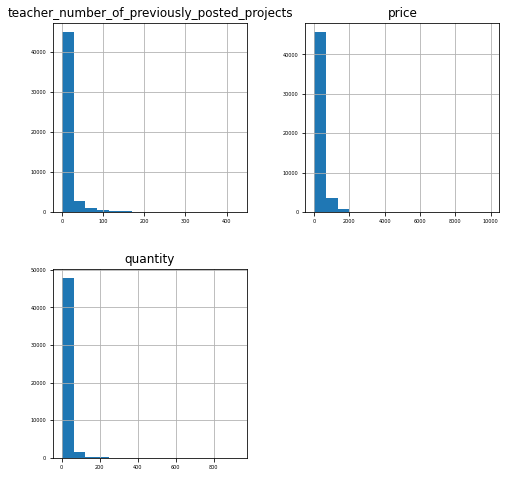

In [9]:
print("\033[1m"+"Histograms:"+"\033[0m")
cont.hist(figsize=(8,8),bins=15,xlabelsize=5,ylabelsize=5)

Bar Plots:
teacher_prefix


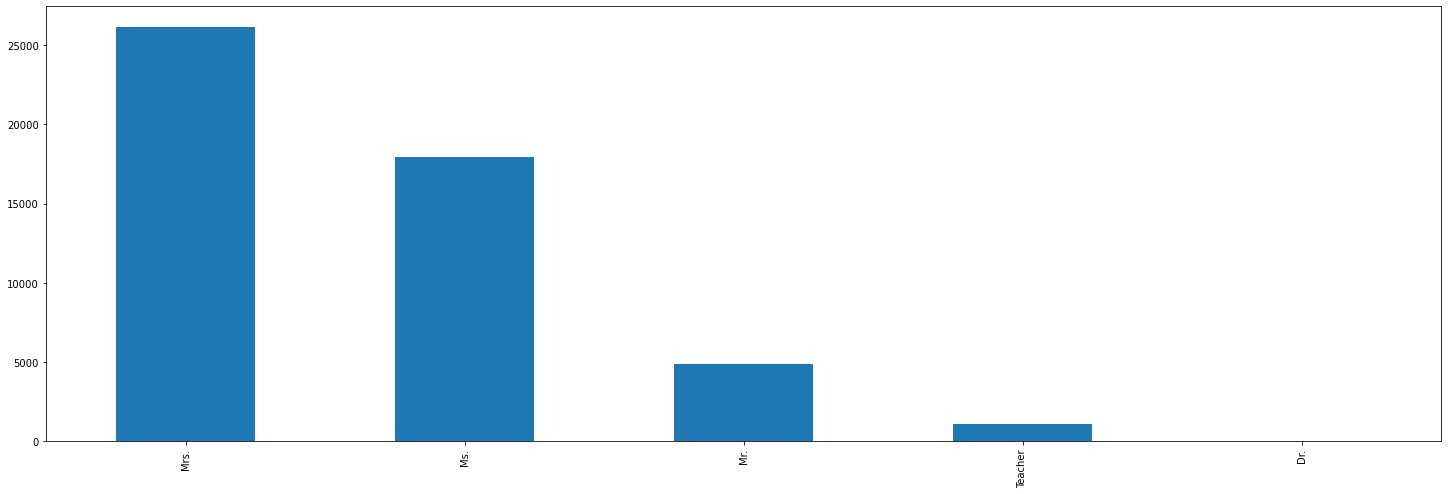

school_state


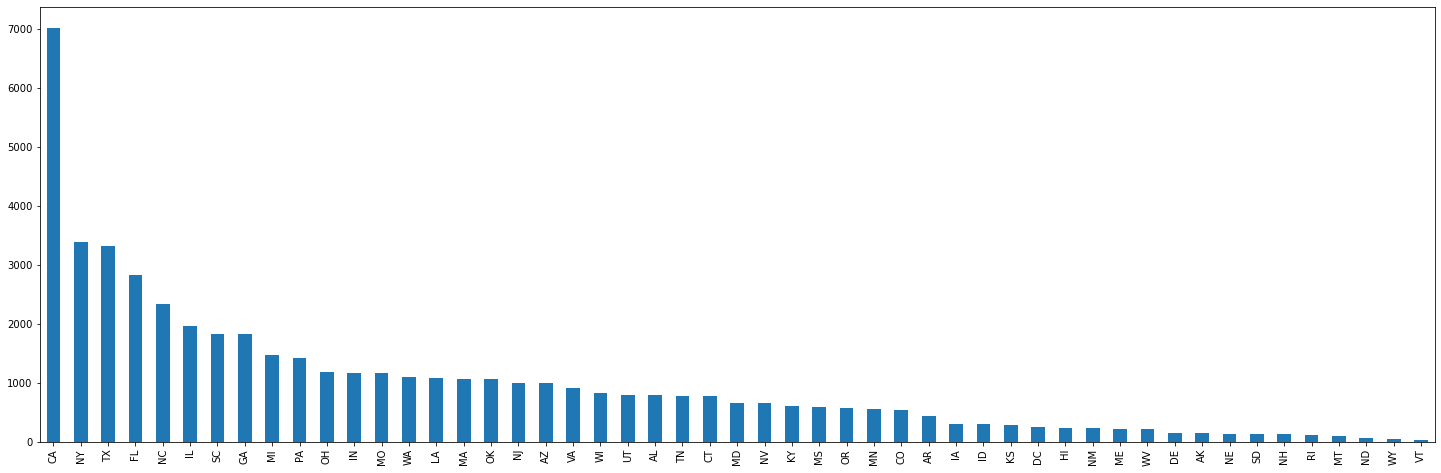

project_grade_category


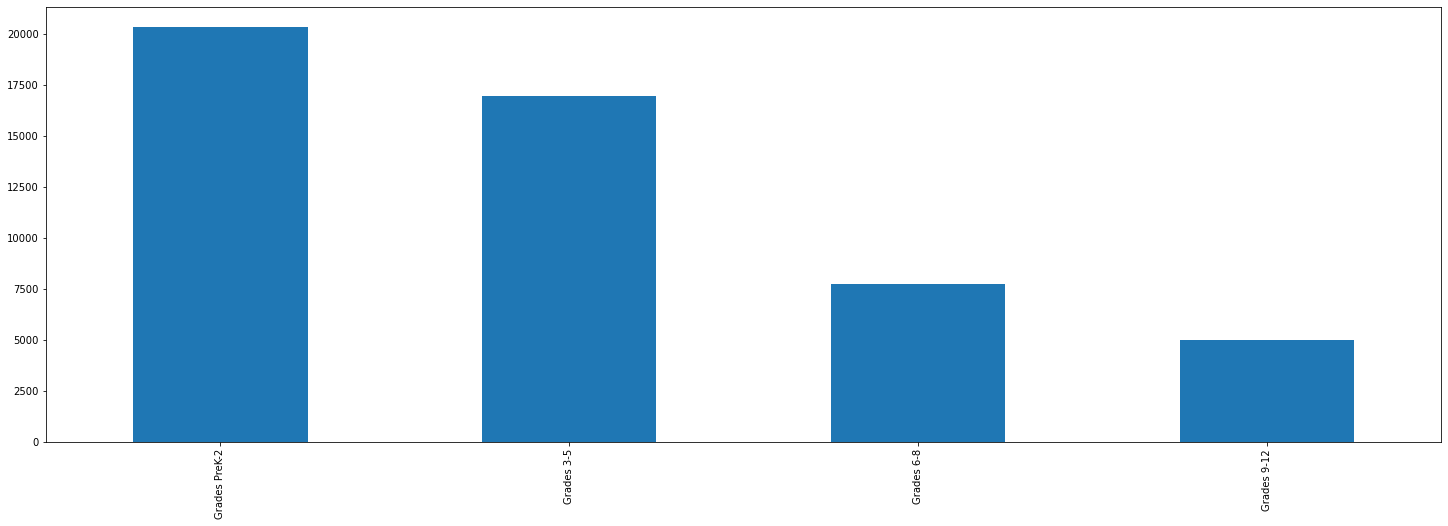

project_subject_categories


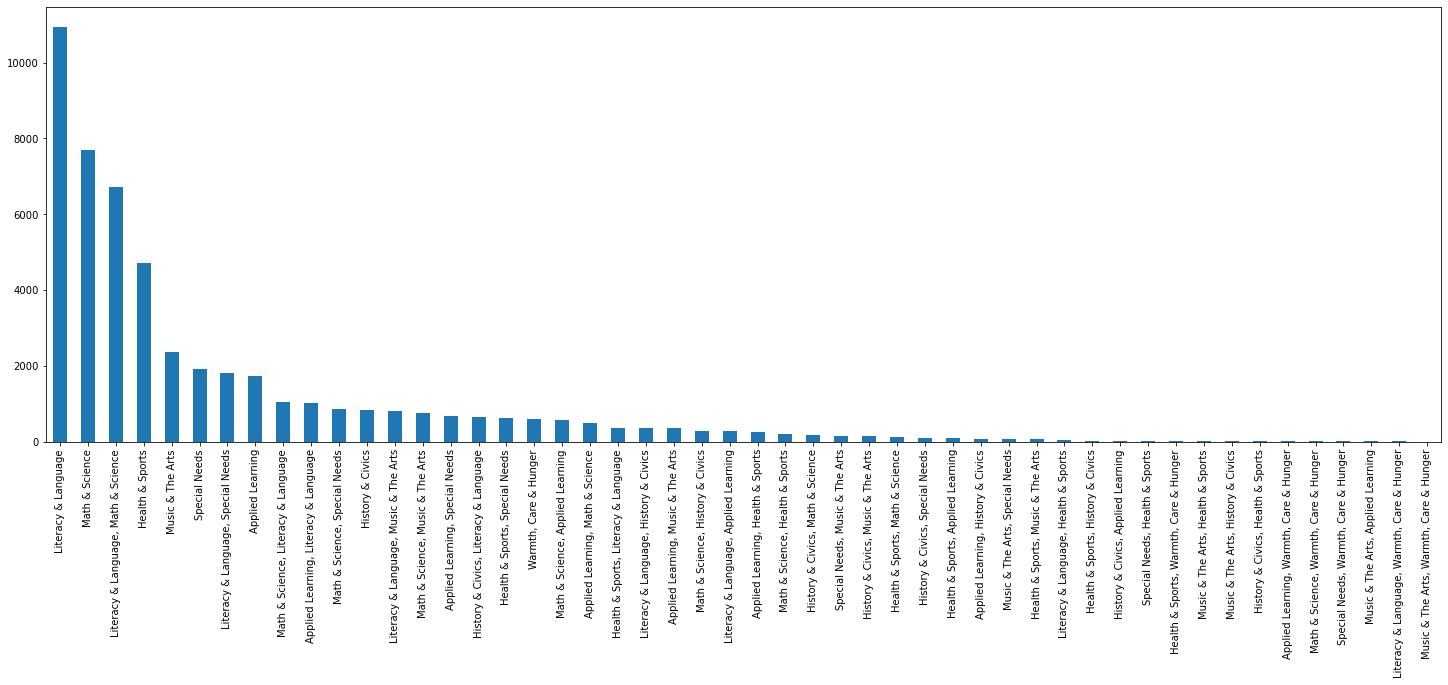

project_subject_subcategories


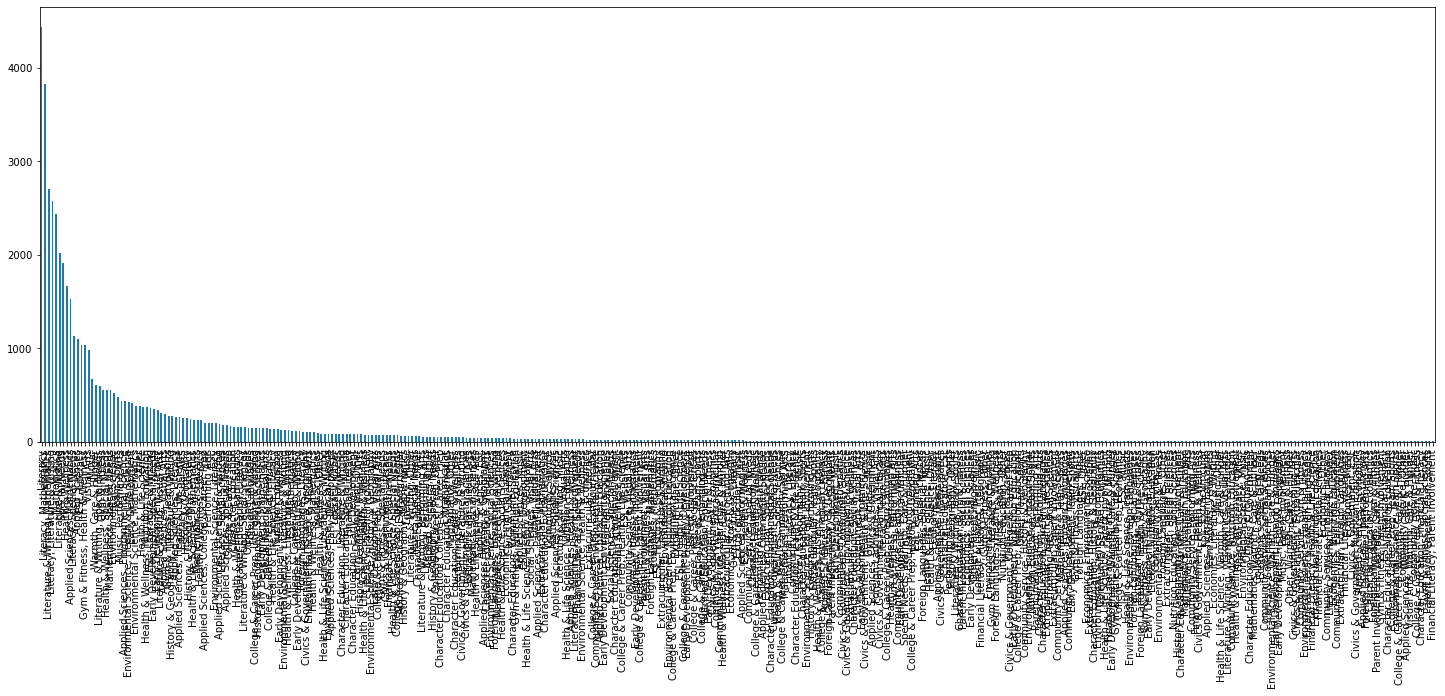

In [10]:
#print("\033[1m"+"Bar Plots:"+"\033[0m")
#for ind,ro in categorical.iteritems():
    #categorical[ind].value_counts().plot(kind='bar',figsize=(8,8))
    #p.show()
desc=['teacher_prefix','school_state','project_grade_category','project_subject_categories','project_subject_subcategories']
ee=['project_resource_summary']
cat=df[desc]
print("\033[1m"+"Bar Plots:"+"\033[0m")
for x in cat.columns:
    print(x)
    cat[x].value_counts().plot(kind='bar',figsize=(25,8))
    p.show()

In [11]:
print(categorical.isnull().sum())#Getting missing values from categorical df

id                                   0
teacher_id                           0
teacher_prefix                       2
school_state                         0
project_submitted_datetime           0
project_grade_category               0
project_subject_categories           0
project_subject_subcategories        0
project_title                        0
project_essay_1                      0
project_essay_2                      0
project_essay_3                  48315
project_essay_4                  48315
project_resource_summary             0
dtype: int64


# 2. Preprocessing Categorical Features: project_grade_category

In [12]:
df['project_grade_category'].value_counts()

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64

we need to remove the spaces, replace the '-' with '_' and convert all the letters to small

In [13]:
df['project_grade_category'] = df['project_grade_category'].str.replace(' ','_')
df['project_grade_category'] = df['project_grade_category'].str.replace('-','_')
df['project_grade_category'] = df['project_grade_category'].str.lower()
df['project_grade_category'].value_counts()

grades_prek_2    20316
grades_3_5       16968
grades_6_8        7750
grades_9_12       4966
Name: project_grade_category, dtype: int64

 # 3. Preprocessing Categorical Features: project_subject_categories

In [14]:
df['project_subject_categories'].value_counts()

Literacy & Language                           10927
Math & Science                                 7695
Literacy & Language, Math & Science            6705
Health & Sports                                4700
Music & The Arts                               2358
Special Needs                                  1913
Literacy & Language, Special Needs             1814
Applied Learning                               1719
Math & Science, Literacy & Language            1041
Applied Learning, Literacy & Language          1018
Math & Science, Special Needs                   871
History & Civics                                839
Literacy & Language, Music & The Arts           794
Math & Science, Music & The Arts                755
Applied Learning, Special Needs                 672
History & Civics, Literacy & Language           651
Health & Sports, Special Needs                  633
Warmth, Care & Hunger                           606
Math & Science, Applied Learning                565
Applied Lear

In [15]:
df['project_subject_categories'] = df['project_subject_categories'].str.replace(' The ','')
df['project_subject_categories'] = df['project_subject_categories'].str.replace(' ','')
df['project_subject_categories'] = df['project_subject_categories'].str.replace('&','_')
df['project_subject_categories'] = df['project_subject_categories'].str.replace(',','_')
df['project_subject_categories'] = df['project_subject_categories'].str.lower()
df['project_subject_categories'].value_counts()

literacy_language                       10927
math_science                             7695
literacy_language_math_science           6705
health_sports                            4700
music_arts                               2358
specialneeds                             1913
literacy_language_specialneeds           1814
appliedlearning                          1719
math_science_literacy_language           1041
appliedlearning_literacy_language        1018
math_science_specialneeds                 871
history_civics                            839
literacy_language_music_arts              794
math_science_music_arts                   755
appliedlearning_specialneeds              672
history_civics_literacy_language          651
health_sports_specialneeds                633
warmth_care_hunger                        606
math_science_appliedlearning              565
appliedlearning_math_science              477
health_sports_literacy_language           369
literacy_language_history_civics  

# 4. Preprocessing Categorical Features: teacher_prefix

In [16]:
df['teacher_prefix'].value_counts()

Mrs.       26140
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64

In [17]:
# check if we have any nan values are there
print(df['teacher_prefix'].isnull().values.any())
print("number of nan values",df['teacher_prefix'].isnull().values.sum())

True
number of nan values 2


>number of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [18]:
df['teacher_prefix']=df['teacher_prefix'].fillna('Mrs.')
df['teacher_prefix'].value_counts()

Mrs.       26142
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64

>Remove '.' <br>
>convert all the chars to small

In [19]:
df['teacher_prefix'] = df['teacher_prefix'].str.replace('.','')
df['teacher_prefix'] = df['teacher_prefix'].str.lower()
df['teacher_prefix'].value_counts()

mrs        26142
ms         17936
mr          4859
teacher     1061
dr             2
Name: teacher_prefix, dtype: int64

# 5. Preprocessing Categorical Features: project_subject_subcategories

In [20]:
df['project_subject_subcategories'].value_counts()

Literacy                                   4434
Literacy, Mathematics                      3833
Literature & Writing, Mathematics          2705
Literacy, Literature & Writing             2570
Mathematics                                2441
                                           ... 
College & Career Prep, Gym & Fitness          1
Character Education, Financial Literacy       1
Gym & Fitness, Social Sciences                1
Parent Involvement, Team Sports               1
Financial Literacy, Parent Involvement        1
Name: project_subject_subcategories, Length: 384, dtype: int64

In [21]:
df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace(' The ','')
df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace(' ','')
df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace('&','_')
df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace(',','_')
df['project_subject_subcategories'] = df['project_subject_subcategories'].str.lower()
df['project_subject_subcategories'].value_counts()

literacy                                4434
literacy_mathematics                    3833
literature_writing_mathematics          2705
literacy_literature_writing             2570
mathematics                             2441
                                        ... 
college_careerprep_gym_fitness             1
charactereducation_financialliteracy       1
gym_fitness_socialsciences                 1
parentinvolvement_teamsports               1
financialliteracy_parentinvolvement        1
Name: project_subject_subcategories, Length: 384, dtype: int64

# 6. Preprocessing Categorical Features: school_state

In [22]:
df['school_state'].value_counts

<bound method IndexOpsMixin.value_counts of 0        IN
1        FL
2        AZ
3        KY
4        TX
         ..
49995    IL
49996    NV
49997    SD
49998    CT
49999    KY
Name: school_state, Length: 50000, dtype: object>

In [23]:
df['school_state'] = df['school_state'].str.lower()
df['school_state'].value_counts()

ca    7024
ny    3393
tx    3320
fl    2839
nc    2340
il    1967
sc    1830
ga    1828
mi    1468
pa    1419
oh    1180
in    1171
mo    1166
wa    1103
la    1094
ma    1076
ok    1074
nj    1005
az     994
va     916
wi     833
ut     792
al     790
tn     774
ct     774
md     668
nv     665
ky     614
ms     598
or     577
mn     556
co     538
ar     446
ia     306
id     302
ks     285
dc     247
hi     239
nm     236
me     222
wv     218
de     155
ak     153
ne     144
sd     142
nh     141
ri     126
mt     106
nd      63
wy      51
vt      32
Name: school_state, dtype: int64

# 7. Preprocessing Categorical Features: project_title

In [24]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [26]:
df['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [27]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [28]:
preprocessed_titles = preprocess_text(df['project_title'].values)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 40968.07it/s]


In [29]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 love reading pure pleasure
34 ball
147 needs chromebook


# 8. Preprocessing Categorical Features: essay

In [30]:
df["essay"] = df["project_essay_1"].map(str) +\
                        df["project_essay_2"].map(str) + \
                        df["project_essay_3"].map(str) + \
                        df["project_essay_4"].map(str)
df.drop(columns=["project_essay_1"],inplace=True)
df.drop(columns=["project_essay_2"],inplace=True)
df.drop(columns=["project_essay_3"],inplace=True)
df.drop(columns=["project_essay_4"],inplace=True)


In [31]:
print("printing some random essay")
print(9, df['essay'].values[9])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [32]:
df["essay"] = preprocess_text(df['essay'].values)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1709.75it/s]


In [33]:
print("printing some random essay")
print(9, df['essay'].values[9])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan


# 8. Preprocessing Numerical Values: price

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['price'].values.reshape(-1, 1))
df['price']=scaler.transform(df['price'].values.reshape(-1, 1))
df['price'].head(10)

0    0.015397
1    0.029839
2    0.051628
3    0.023228
4    0.006733
5    0.011258
6    0.015936
7    0.022838
8    0.024136
9    0.012472
Name: price, dtype: float64

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['quantity'].values.reshape(-1, 1))
df['quantity']=scaler.transform(df['quantity'].values.reshape(-1, 1))
df['quantity'].head(10)

0    0.023681
1    0.000000
2    0.022605
3    0.003229
4    0.003229
5    0.010764
6    0.002153
7    0.003229
8    0.005382
9    0.013994
Name: quantity, dtype: float64

## 9. Preprocessing NumericalValues:teacher_number_of_previously_posted_projects	

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
df['teacher_number_of_previously_posted_projects']=scaler.transform(df['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
df['teacher_number_of_previously_posted_projects'].head(10)

0    0.000000
1    0.016355
2    0.002336
3    0.009346
4    0.002336
5    0.002336
6    0.002336
7    0.016355
8    0.065421
9    0.084112
Name: teacher_number_of_previously_posted_projects, dtype: float64

In [37]:
# check if we have any nan values are there
print(df['teacher_number_of_previously_posted_projects'].isnull().values.any())
print("number of nan values",df['teacher_number_of_previously_posted_projects'].isnull().values.sum())

False
number of nan values 0


In [38]:
print("\033[1m"+"Lower range Upper Range and InterQuartile Range(IQR)"+"\033[0m")
for i in cont:
    Q1,Q2,Q3=0.25,0.50,0.75
    x=cont[i].quantile([Q1,Q2,Q3])
    x=x.rename({0.25:"Quartile1",0.50:"Quartile2",0.75:"Quartile3"})
    IQR=x["Quartile3"]-x["Quartile1"]
    lower_range = x['Quartile1'] - (1.5 * IQR)
    upper_range = x['Quartile3'] + (1.5 * IQR)
    print("For",i,"Lower Range:",lower_range,"Upper Range:",upper_range,"IQR:",IQR)

Lower range Upper Range and InterQuartile Range(IQR)
For teacher_number_of_previously_posted_projects Lower Range: -13.5 Upper Range: 22.5 IQR: 9.0
For price Lower Range: -305.6237500000001 Upper Range: 788.4262500000001 IQR: 273.51250000000005
For quantity Lower Range: -21.5 Upper Range: 46.5 IQR: 17.0


teacher_number_of_previously_posted_projects
price
quantity


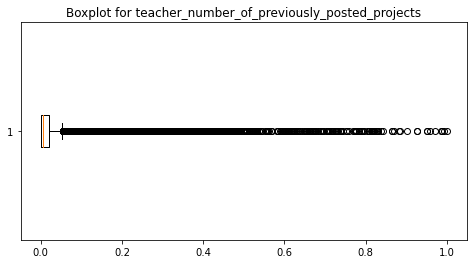

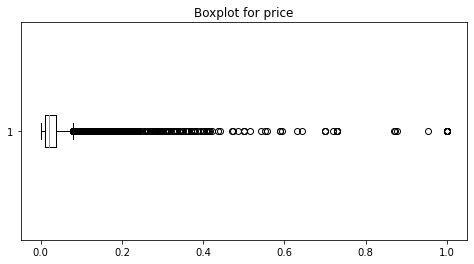

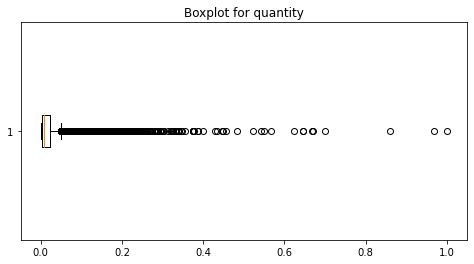

In [39]:
for name in cont.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title('Boxplot for '+ name)                                 
    plt.boxplot(df[name], vert = False)
    print(name)

In [40]:
def get_bounds(col):
    sorted(col)
    Q1,Q3 = np.percentile(col , [25,75])
    IQR = Q3 - Q1
    lr = Q1 - (1.5 * IQR)
    ur = Q3 + (1.5 * IQR)
    return lr,ur

for col in cont:
    lr,ur = get_bounds(df[col])
    df[col] = np.clip(df[col], lr, ur)
df

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,price,quantity,essay
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,12/5/2016 13:43,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0.000000,0.015397,0.023681,students english learners working english seco...
1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,10/25/2016 9:22,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,0.016355,0.029839,0.000000,students arrive school eager learn polite gene...
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,8/31/2016 12:03,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,"My students need shine guards, athletic socks,...",0.002336,0.051628,0.022605,true champions not always ones win guts mia ha...
3,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,10/6/2016 21:16,grades_prek_2,literacy_language_math_science,literacy_mathematics,Techie Kindergarteners,My students need to engage in Reading and Math...,0.009346,0.023228,0.003229,work unique school filled esl english second l...
4,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,7/11/2016 1:10,grades_prek_2,math_science,mathematics,Interactive Math Tools,My students need hands on practice in mathemat...,0.002336,0.006733,0.003229,second grade classroom next year made around 2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,p144673,88a8bdd51dca790df61b3cc2fafdae14,mrs,il,9/5/2016 21:25,grades_prek_2,literacy_language_math_science,literacy_mathematics,iTeach: Using iPads in Instruction,My students need iPads to help customize learn...,0.018692,0.053941,0.001076,teach kindergarten title school chicago many s...
49996,p138289,df7a55562859452b3aa897c3f3a53d19,mr,nv,4/20/2017 1:29,grades_3_5,health_sports,health_wellness,"A \""Starbucks\"" Classroom Redesign",My students need Hokki Stools to maximize enga...,0.014019,0.021350,0.005382,students room enrolled elementary school reno ...
49997,p159292,30f3dd18199ab24d10e6c8fdc1a877f8,mrs,sd,8/22/2016 16:46,grades_3_5,health_sports,health_wellness,Active Bodies = Active Minds,My students need 12 Learniture Active Learning...,0.021028,0.005140,0.013994,welcome students pleased take interest educati...
49998,p094764,bdf30a7b220e6b90218acbc57cf73440,mrs,ct,1/29/2017 12:56,grades_prek_2,literacy_language_specialneeds,literature_writing_specialneeds,Can You Read My Writing Now?,"My students need Dimples hand strengthener, th...",0.052570,0.010161,0.005382,school empowers 538 students grades pre k five...


6206
teacher_number_of_previously_posted_projects
price
quantity


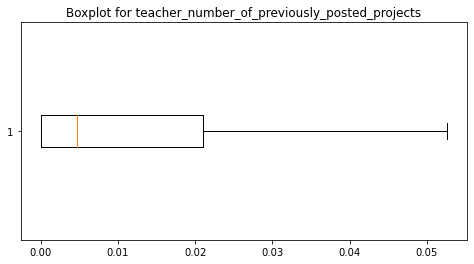

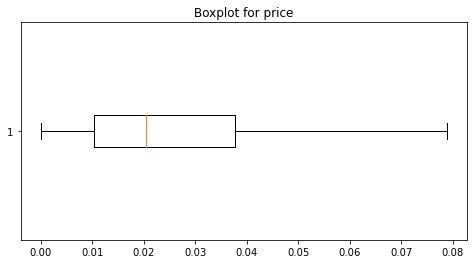

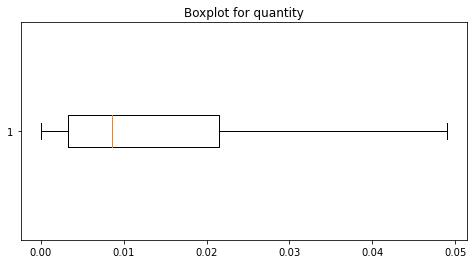

In [41]:
Uoutliers=np.where((cont["teacher_number_of_previously_posted_projects"]>=22.5) | (cont["teacher_number_of_previously_posted_projects"]<=-13.5))
print(len(Uoutliers[0]))
#for name in continous_df['Feature'].to_list():   
for name in cont.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title('Boxplot for '+ name)                                 
    plt.boxplot(df[name], vert = False)
    print(name)

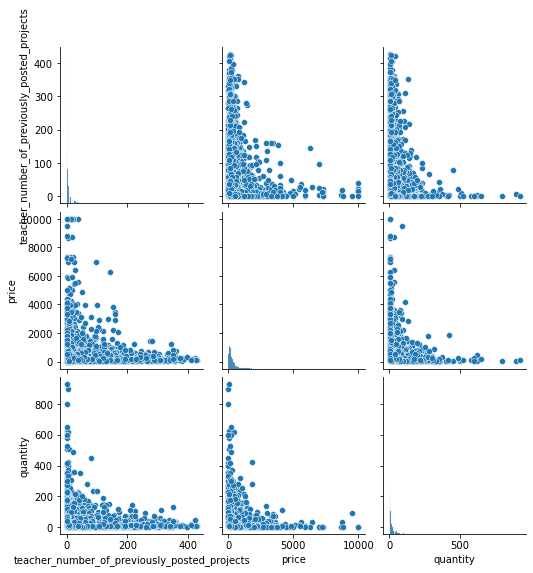

In [42]:
#ScatterPlot
import seaborn as s
s.pairplot(cont)

<AxesSubplot:>

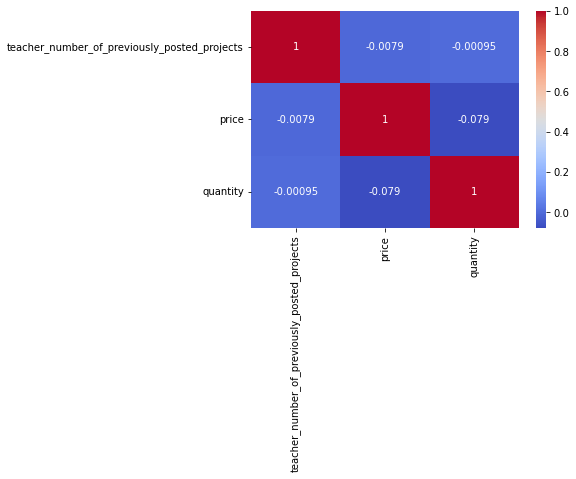

In [43]:
#Correlation Matrix
s.heatmap(cont.corr(),annot = True, cmap = "coolwarm")

In [44]:
df=pd.concat([df,pd.DataFrame(Y)],axis=1)
df.to_csv("Clean_data.csv",index=False)

In [45]:
df

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,price,quantity,essay,project_is_approved
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,12/5/2016 13:43,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0.000000,0.015397,0.023681,students english learners working english seco...,0
1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,10/25/2016 9:22,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,0.016355,0.029839,0.000000,students arrive school eager learn polite gene...,1
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,8/31/2016 12:03,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,"My students need shine guards, athletic socks,...",0.002336,0.051628,0.022605,true champions not always ones win guts mia ha...,0
3,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,10/6/2016 21:16,grades_prek_2,literacy_language_math_science,literacy_mathematics,Techie Kindergarteners,My students need to engage in Reading and Math...,0.009346,0.023228,0.003229,work unique school filled esl english second l...,1
4,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,7/11/2016 1:10,grades_prek_2,math_science,mathematics,Interactive Math Tools,My students need hands on practice in mathemat...,0.002336,0.006733,0.003229,second grade classroom next year made around 2...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,p144673,88a8bdd51dca790df61b3cc2fafdae14,mrs,il,9/5/2016 21:25,grades_prek_2,literacy_language_math_science,literacy_mathematics,iTeach: Using iPads in Instruction,My students need iPads to help customize learn...,0.018692,0.053941,0.001076,teach kindergarten title school chicago many s...,1
49996,p138289,df7a55562859452b3aa897c3f3a53d19,mr,nv,4/20/2017 1:29,grades_3_5,health_sports,health_wellness,"A \""Starbucks\"" Classroom Redesign",My students need Hokki Stools to maximize enga...,0.014019,0.021350,0.005382,students room enrolled elementary school reno ...,1
49997,p159292,30f3dd18199ab24d10e6c8fdc1a877f8,mrs,sd,8/22/2016 16:46,grades_3_5,health_sports,health_wellness,Active Bodies = Active Minds,My students need 12 Learniture Active Learning...,0.021028,0.005140,0.013994,welcome students pleased take interest educati...,1
49998,p094764,bdf30a7b220e6b90218acbc57cf73440,mrs,ct,1/29/2017 12:56,grades_prek_2,literacy_language_specialneeds,literature_writing_specialneeds,Can You Read My Writing Now?,"My students need Dimples hand strengthener, th...",0.052570,0.010161,0.005382,school empowers 538 students grades pre k five...,1
